3.DATASET
The dataset for this paper has been obtained 
from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Automobile).

This data set consists of three types of entities: (a) the specification of an auto in terms of various 
characteristics, (b)its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.

The second rating corresponds to the degree to which the auto is more risky than its price indicates.
Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky 
(or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process 
“symboling”. A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized 
for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc…),
and represents the average loss per car per year.

There are total 205 instances and 26 attributes out of which 15 are continuous, 1 is integer and 
10 are nominal. There are missing values as well.

## Outliers

An outlier is a data point which is significantly different from the remaining data. "An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism." [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980.]


### Should outliers be removed?

Depending on the context, outliers either deserve special attention or should be completely ignored. Take the example of revenue forecasting: if unusual spikes of revenue are observed, it's probably a good idea to pay extra attention to them and figure out what caused the spike. In the same way, an unusual transaction on a credit card is usually a sign of fraudulent activity, which is what the credit card issuer wants to prevent. So in instances like these, it is useful to look for and investigate further outlier values.

If outliers are however, introduced due to mechanical error, measurement error or anything else that can't be generalised, it is a good idea to remove these outliers before feeding the data to the modeling algorithm. Why? Because some algorithms are sensitive to outliers. 


### Which machine learning models are sensitive to outliers?

Some machine learning models are more sensitive to outliers than others. For instance, AdaBoost may treat outliers as "hard" cases and put tremendous weights on outliers, therefore producing a model with bad generalisation.

Linear models, in particular Linear Regression, can be also sensitive to outliers.

Decision trees tend to ignore the presence of outliers when creating the branches of their trees. Typically, trees make decisions by asking if variable x >= a certain value, and therefore the outlier will fall on each side of the branch, but it will be treated equally than the remaining values, regardless of its magnitude.

A recent research article suggests that Neural Networks could also be sensitive to outliers, provided the number of outliers is high and the deviation is also high. I would argue that if the number of outliers is high (>15% as suggested in the article), then they are no longer outliers, and rather a fair representation of that variable. A link to this article can be found in the "Additional reading resources" lecture within this section of the course.


### How can outliers be identified?

Outlier analysis and anomaly detection are a huge field of research devoted to optimise methods and create new algorithms to reliably identify outliers. There are a huge number of ways optimised to detect outliers in different situations. These are mostly targeted to identify outliers when those are the observations that we indeed want to focus on, for example for fraudulent credit card activity.

In this course, however, I will focus on identifying those outliers introduced by mechanical or measurement error. Those outliers that are indeed a rare case in the population, and that could be ignored. I will show how to identify those outliers.

### Extreme Value Analysis

The most basic form of outlier detection is **Extreme Value Analysis** of 1-dimensional data. The key for this method is to determine the statistical tails of the underlying distribution of the variable, and then find the values that sit at the very end of the tails.

If the the variable is Normally distributed (Gaussian), then the values that lie outside the mean plus or minus 3 times the standard deviation of the variable are considered outliers.

- outliers = mean +/- 3* std


If the variable is skewed distributed, a general approach is to calculate the quantiles, and then the inter-quantile range (IQR), as follows:

- IQR = 75th quantile - 25th quantile

An outlier will sit outside the following upper and lower boundaries:

- Upper boundary = 75th quantile + (IQR * 1.5)

- Lower boundary = 25th quantile - (IQR * 1.5)

or for extreme cases:

- Upper boundary = 75th quantile + (IQR * 3)

- Lower boundary = 25th quantile - (IQR * 3)

We will:

Identify outliers using complete case analysis in Normally distributed variables.
Identify outliers using complete case analysis in skewed variables.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import pylab
import scipy.stats as stats

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [2]:
# let's load the imports-85-clean-data.csv dataset

data = pd.read_csv('C:\\Users\\gusal\\machine learning\\Feature engineering\\automobile data set\\imports-85-clean-data.csv')


In [3]:
# let's inspect the first 5 rows
data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,128.414508,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,13495.0
1,3,128.414508,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,16500.0
2,1,128.414508,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500.0,18,22,17450.0


In [4]:
data.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower             int64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

## Identify variable distribution

In Normally distributed variables, outliers are those values that lie beyond the mean plus or minus 3 times the standard deviation. If the variables are skewed however, we find outliers using the inter-quantile range. In order to decide which method to utilise to detect outliers, we first need to know the distribution of the variable.

We can use histograms and Q-Q plots to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable utilising the first quartile, the median, the third quartile and the whiskers.

Looking at a boxplot, you can easily identify:

- The median, indicated by the line within the box.
- The inter-quantile range (IQR), the box itself.
- The quantiles, 25th (Q1) is the lower and 75th (Q3) the upper end of the box.
- The wiskers, which extend to: 
  -- top whisker: Q3 + 1.5 x IQR
  -- bottom whisker: Q1 -1.5 x IQR

Any value sitting outside the whiskers is considered an outlier. Let's look at the examples below.

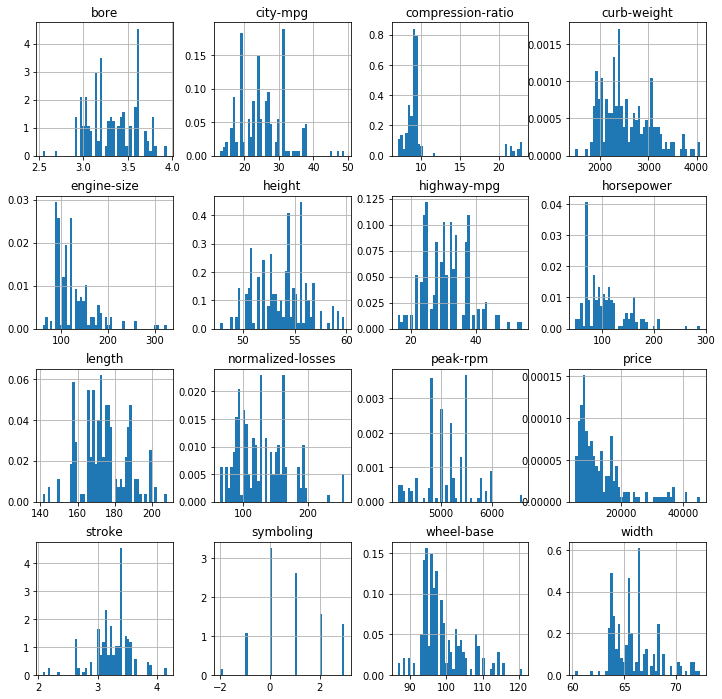

In [5]:
# plot the histograms for all numerival variables in the complete
# case dataset 

data.hist(bins=50, density=True, figsize=(12, 12))
plt.show()

### There are not normally distributed variable.
### All are skewed.

In [6]:
# function to create histogram, Q-Q plot and
# boxplot


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.ylabel('value')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [7]:

### Skewed variables

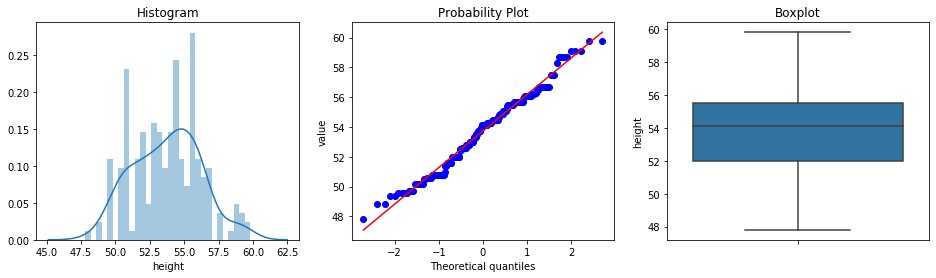

In [8]:
# let's start with the variable engine-size from the
# automobile dataset.

diagnostic_plots(data, 'height')

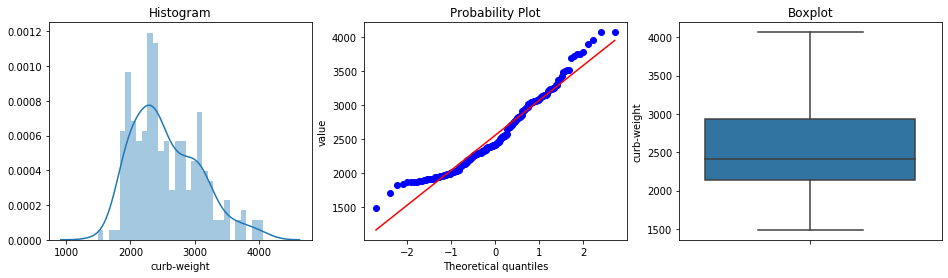

In [9]:

diagnostic_plots(data, 'curb-weight')

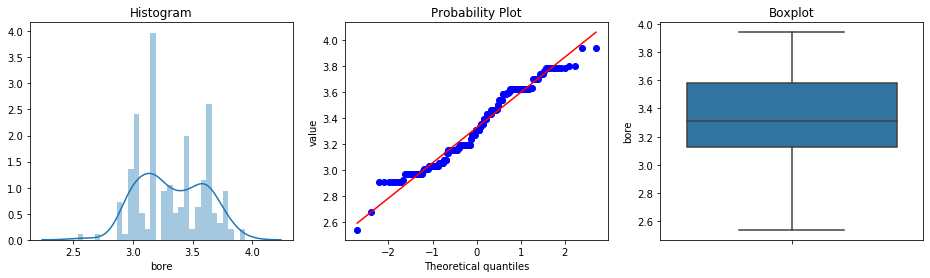

In [10]:
diagnostic_plots(data, 'bore')

### There are not outliers for the variables 'bore', 'curb-weight' and 'height' according to the boxplot.

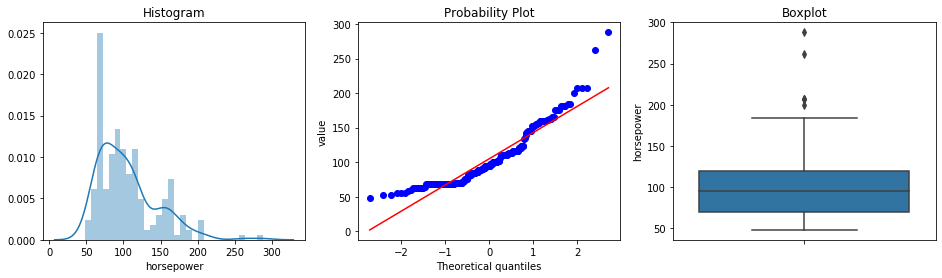

In [11]:
diagnostic_plots(data, 'horsepower')

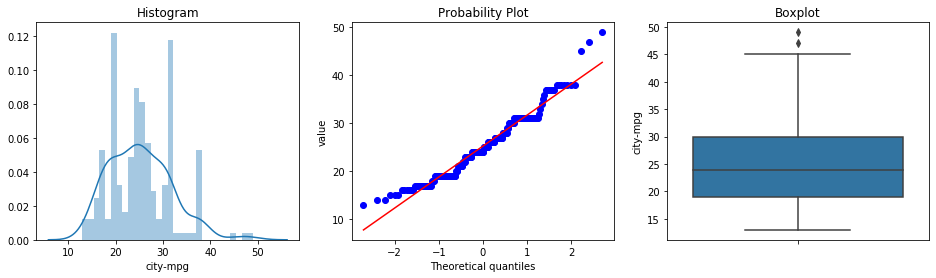

In [12]:
diagnostic_plots(data, 'city-mpg')

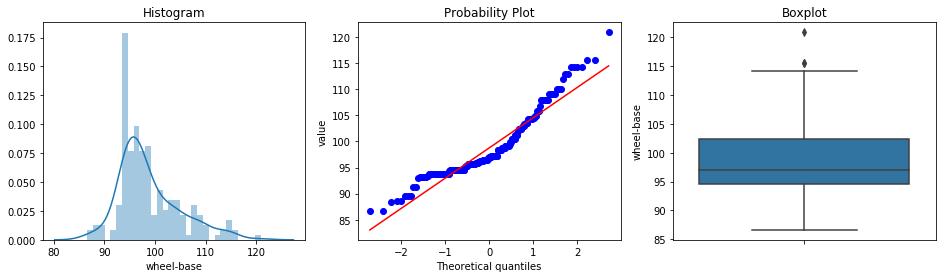

In [13]:
diagnostic_plots(data, 'wheel-base')

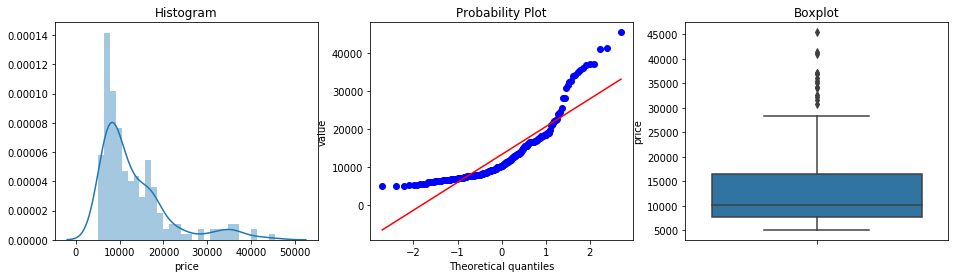

In [14]:
diagnostic_plots(data, 'price')

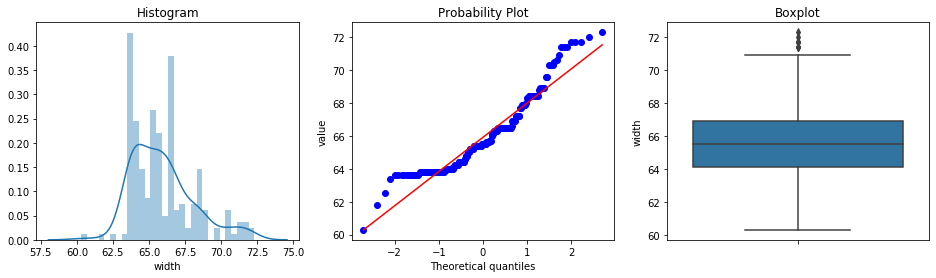

In [15]:
diagnostic_plots(data, 'width')

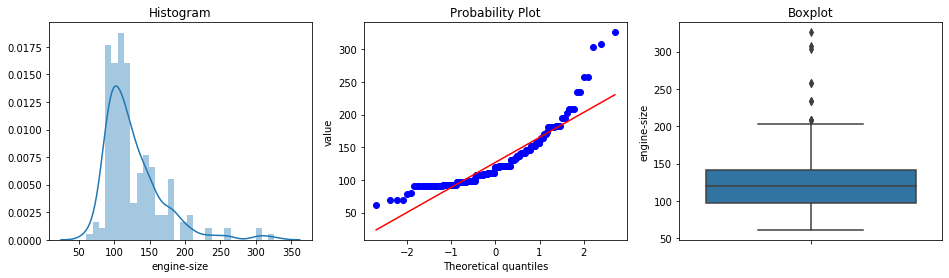

In [16]:
diagnostic_plots(data, 'engine-size')

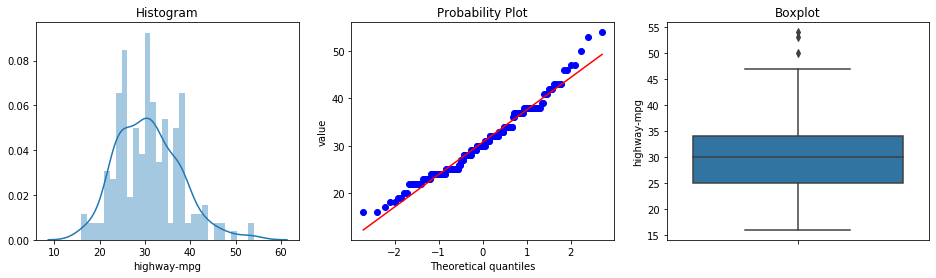

In [17]:
diagnostic_plots(data, 'highway-mpg')

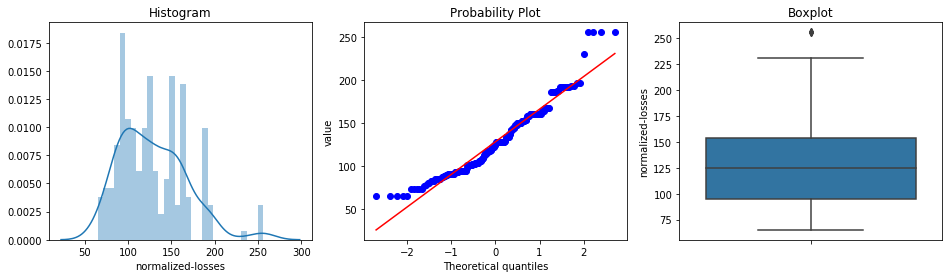

In [18]:
diagnostic_plots(data, 'normalized-losses')

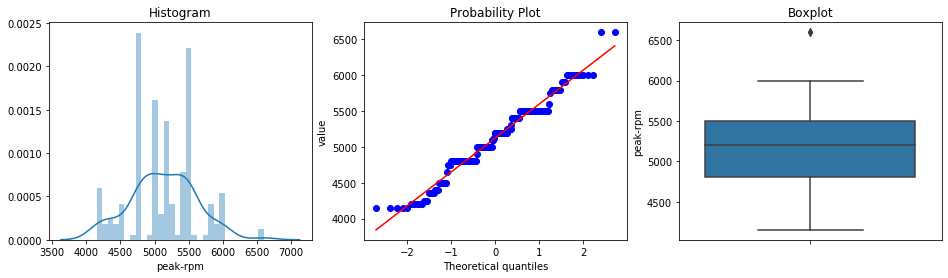

In [19]:
diagnostic_plots(data, 'peak-rpm')

In [20]:
### the graphics show some unusual values at the right end of its distribution for the variables 'normalized-losses', 
###'peak-rpm' ,'highway-mpg', 'horsepower', 'city-mpg', 'wheel-base', 'price', 'width','engine-size'  
### according to the boxplot.

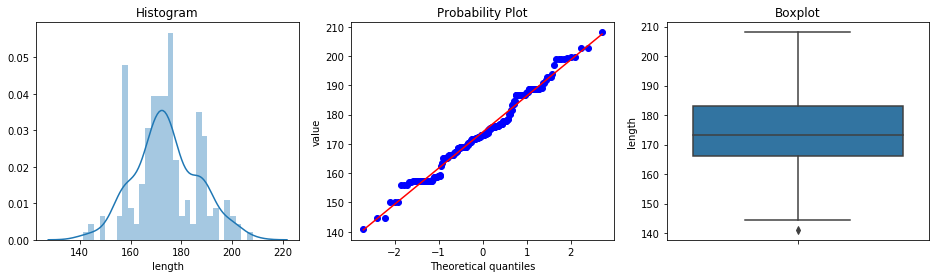

In [21]:
diagnostic_plots(data, 'length')

In [22]:
### shows some unusual values at the left end of its distribution for the variable 'length' 
### according to the boxplot.

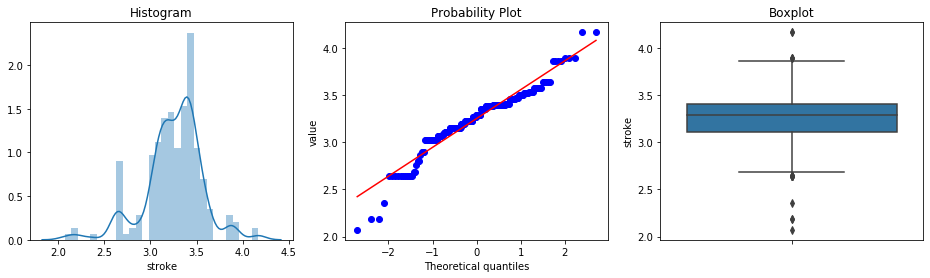

In [23]:
diagnostic_plots(data, 'stroke')

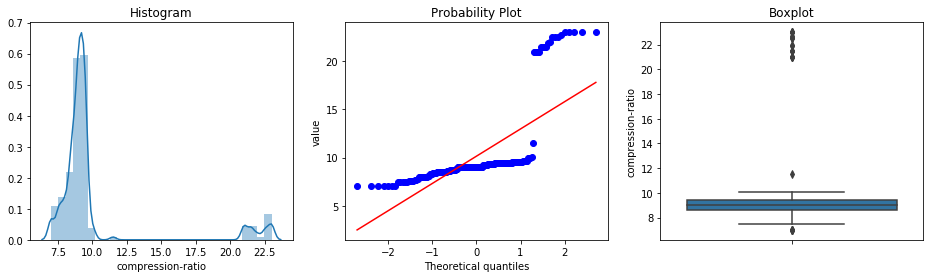

In [24]:
diagnostic_plots(data, 'compression-ratio')

In [25]:
### shows some unusual values at the left and right end of its distribution for the variables 
###'stroke' and 'compression-ratio' 
### according to the boxplot.

In [26]:
## we do not have Outliers for Normally distributed variables
###  check below the formula for Outlier detection for Normally distributed variables

# function to find upper and lower boundaries
# for normally distributed variables


def find_normal_boundaries(df, variable):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

# calculate boundaries for 'varible'
upper_boundary, lower_boundary = find_normal_boundaries(df, 'varible')
upper_boundary, lower_boundary

### Outlier detection for skewed variables¶

In [27]:
# function to find upper and lower boundaries
# for skewed distributed variables


def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [28]:
### making a function to find the outliers one by one

def outliers (variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    upper_boundary, lower_boundary = find_skewed_boundaries(data, variable, 1.5)
    upper_boundary, lower_boundary
    
    upper_boundary = round(upper_boundary,2)
    lower_boundary = round(lower_boundary,2)

    
    print('total automobiles: {}'.format(len(data)))

    print('automobiles with ' +  variable + ' bigger than ' + str(upper_boundary) + ': {}'.format(
    len(data[data[variable] > upper_boundary])))
    print()
    print('% automobiles with ' +  variable + ' bigger than ' + str(upper_boundary) + ': {}'.format(
    round(len(data[data[variable] > upper_boundary])*100/len(data),2)))
    
    print('total automobiles: {}'.format(len(data)))

    print('automobiles with ' +  variable + ' smaller than ' + str(lower_boundary) + ': {}'.format(
    len(data[data[variable] < lower_boundary])))
    print()
    print('% automobiles with ' +  variable + ' smaller than ' + str(lower_boundary) + ': {}'.format(
    round(len(data[data[variable] < lower_boundary])*100/len(data),2)))
    
    

In [29]:
outliers ('compression-ratio')

total automobiles: 205
automobiles with compression-ratio bigger than 10.6: 21

% automobiles with compression-ratio bigger than 10.6: 10.24
total automobiles: 205
automobiles with compression-ratio smaller than 7.4: 7

% automobiles with compression-ratio smaller than 7.4: 3.41


In [30]:
outliers ('stroke')

total automobiles: 205
automobiles with stroke bigger than 3.86: 5

% automobiles with stroke bigger than 3.86: 2.44
total automobiles: 205
automobiles with stroke smaller than 2.66: 15

% automobiles with stroke smaller than 2.66: 7.32


In [31]:
outliers ('engine-size')

total automobiles: 205
automobiles with engine-size bigger than 207.0: 10

% automobiles with engine-size bigger than 207.0: 4.88
total automobiles: 205
automobiles with engine-size smaller than 31.0: 0

% automobiles with engine-size smaller than 31.0: 0.0


In [32]:
outliers ('price')

total automobiles: 205
automobiles with price bigger than 29595.0: 15

% automobiles with price bigger than 29595.0: 7.32
total automobiles: 205
automobiles with price smaller than -5317.0: 0

% automobiles with price smaller than -5317.0: 0.0


In [33]:
outliers ('horsepower')

total automobiles: 205
automobiles with horsepower bigger than 195.0: 6

% automobiles with horsepower bigger than 195.0: 2.93
total automobiles: 205
automobiles with horsepower smaller than -5.0: 0

% automobiles with horsepower smaller than -5.0: 0.0


In [34]:
outliers ('curb-weight')

total automobiles: 205
automobiles with curb-weight bigger than 4120.0: 0

% automobiles with curb-weight bigger than 4120.0: 0.0
total automobiles: 205
automobiles with curb-weight smaller than 960.0: 0

% automobiles with curb-weight smaller than 960.0: 0.0


# creating a function that make a summary of the quantity of outliers and lower and upper boundaries per variable 

### first, selecting the numerical variables from the data set

In [35]:
data.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [36]:
# making a list of numerical variables. we will find the outliers for this variables
list_variables = ['normalized-losses', 'wheel-base', 'length', 'width', 'height','curb-weight', 'engine-size',
                  'bore', 'stroke', 'compression-ratio', 'horsepower','peak-rpm', 'city-mpg', 'highway-mpg', 'price']

In [37]:
data_upper_boundary = [] # this list will store the upper boundary per each variable
data_lower_boundary = [] # this list will store the lower boundary per each variable
upperOutliers = [] # this list will store the lower outlier per each variable   
lowerOutliers = [] # this list will store the lower outlier per each variable
for i in list_variables:
    upper_boundary, lower_boundary = find_skewed_boundaries(data, i, 1.5)
    upp = np.count_nonzero(data[i] > upper_boundary)
    low = np.count_nonzero(data[i] < lower_boundary)
    upperOutliers.append(upp)
    lowerOutliers.append(low)
    data_upper_boundary.append(upper_boundary)
    data_lower_boundary.append(lower_boundary)
    

In [38]:
data_upper_boundary = np.around(data_upper_boundary,2)

In [39]:
data_lower_boundary = np.around(data_lower_boundary,2)

In [40]:
outliers_variable = pd.DataFrame(list_variables, columns = ['variables'])

In [41]:
outliers_variable['qty_upperOutliers'] = upperOutliers
outliers_variable['qty_lowerOutliers'] = lowerOutliers
outliers_variable['upper_boundary'] = data_upper_boundary
outliers_variable['lower_boundary'] = data_lower_boundary

In [42]:
outliers_variable

,variables,qty_upperOutliers,qty_lowerOutliers,upper_boundary,lower_boundary
0,normalized-losses,4,0,242.50,6.50
1,wheel-base,3,0,114.25,82.65
2,length,0,1,208.30,141.10
3,width,8,0,71.10,59.90
4,height,0,0,60.75,46.75
5,curb-weight,0,0,4120.00,960.00
6,engine-size,10,0,207.00,31.00
7,bore,0,0,4.26,2.45
8,stroke,5,15,3.86,2.66
9,compression-ratio,21,7,10.60,7.40


In [68]:
outliers_only = outliers_variable[outliers_variable['qty_upperOutliers'] != 0 & (outliers_variable['qty_lowerOutliers'] != 0)]

In [69]:
outliers_only

,variables,qty_upperOutliers,qty_lowerOutliers,upper_boundary,lower_boundary
0,normalized-losses,4,0,242.50,6.50
1,wheel-base,3,0,114.25,82.65
3,width,8,0,71.10,59.90
6,engine-size,10,0,207.00,31.00
8,stroke,5,15,3.86,2.66
9,compression-ratio,21,7,10.60,7.40
10,horsepower,6,0,195.00,-5.00
11,peak-rpm,2,0,6550.00,3750.00
12,city-mpg,2,0,46.50,2.50
13,highway-mpg,3,0,47.50,11.50
